reading data into python: shows the number of women who use contraception for different ages

In [2]:
!pip install pyreadr
import pyreadr
result = pyreadr.read_r('contracep.RData')
C = result['contracep']
C

     |████████████████████████████████| 419kB 6.5MB/s 


,age,total,use
0,18.0,35.0,16.0
1,19.0,27.0,17.0
2,20.0,29.0,12.0
3,21.0,27.0,13.0
4,22.0,35.0,26.0
5,23.0,34.0,23.0
6,24.0,33.0,28.0
7,25.0,26.0,23.0
8,26.0,28.0,26.0
9,27.0,29.0,23.0


we first visualise the data: since we have varying numbers of observations depending on the age, we plot the proportion of women which use contraception, rather than raw figures

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


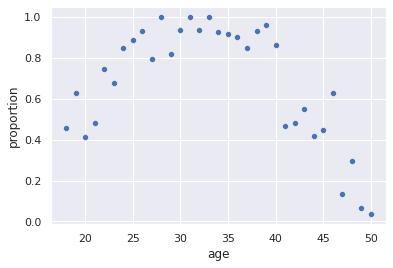

In [3]:
prop = C.use / C.total
C['proportion'] = prop

import seaborn as sns
sns.set_theme(style='darkgrid')
sns.scatterplot(C.age, C.proportion)

now we attempt to specify a suitable model for this data. Note that n_i women of age z_i were asked if they use contraceptives (n_i's in column 'total', z_i's in column 'age'). We let y_i be the number of women of age z_i using contraceptives and assume that y_i is binomially distributed i.e. y_i ~ Bin(n_i, p_i) where p_i = PHI(t_i) with t_i = beta_0 + beta_1 * z_i . Here PHI() denotes the cumulative distribution function of the standard normal, and this model is referred to as a probit model.

With the model specified we seek to find the values of the parameters beta_0 and beta_1, which we will achieve by using the Hamiltonian Monte Carlo algorithm to obtain samples from our posterior distribution (with uninformative Gaussian priors).

0.9242


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


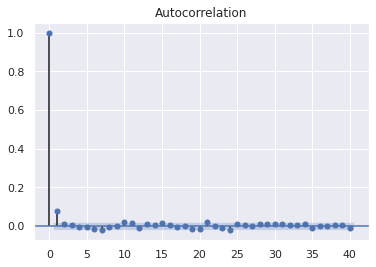

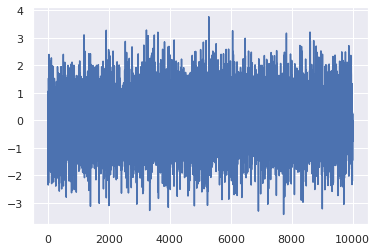

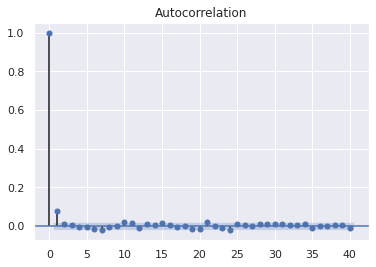

In [4]:
"First we use the HMC algorithm with the standard normal as target distribution"
"to check it works" 
import numpy as np
import math

def HMC(U, gradU, epsilon, L, currentq, n):
  samples = np.zeros(n)
  accept = 0*currentq
  for j in range(0, n-1):
    q = currentq
    p = np.random.normal(size=1) 
    currentp = p
    "perform L leapfrog steps"
    p = p - epsilon*gradU(q)/2
    for i in range(1, L):
      q = q + epsilon*p
      if i != L:
        p = p - epsilon*gradU(q)
    p = p - epsilon*gradU(q)/2
    p = -p
    "calculate inital and proposed potential and kinetic energies"
    currentU = U(currentq)
    proposedU = U(q)
    currentK = sum(0.5*(currentp**2))
    proposedK = sum(0.5*(p**2))
    "Metropolis acceptance rule"
    if np.random.uniform(size=1) < math.exp(currentU+currentK - proposedU - proposedK):
      currentq = q
      accept = accept + 1
    samples[j] = currentq   
  return [samples, accept]   

"define potential energy function (minus log of target distribution)"
def U(x):
  val = 0.5*(x**2) + math.log(math.sqrt(2*math.pi))
  return val
"gradient of potential energy function"  
def gradU(x):
  return x

n=10000
[results, accrate] = HMC(U, gradU, 0.25, 7, 0, n) 
"Tune epsilon and L appropriately to obtain low autocorrelation"
print(accrate/n)
sns.lineplot(x=range(n), y=results)
import statsmodels.graphics.tsaplots
statsmodels.graphics.tsaplots.plot_acf(results)

Compare density of our samples with the density of the actual standard normal, to prove the algorithm is working

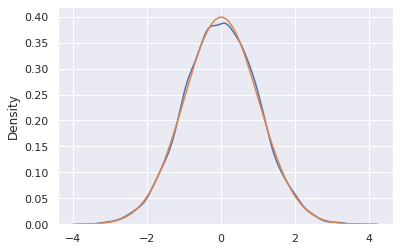

In [5]:
import scipy.stats
sns.kdeplot(results)
xx = np.arange(-4, 4, 0.01)
yy = scipy.stats.norm.pdf(xx)
sns.lineplot(x=xx, y=yy)

0.589


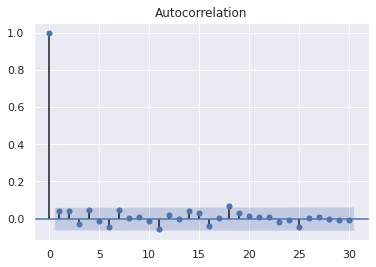

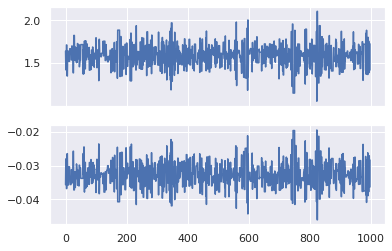

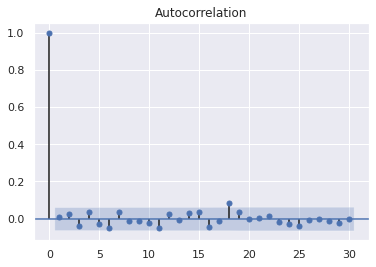

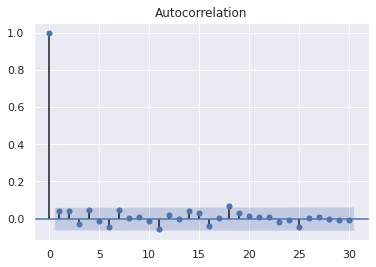

In [12]:
"Now we use HMC (with different stepsizes for each target variable)" 
"to obtain samples from our posterior distribution" 
def HMC(U, gradU, epsilons, L, currentq, n):
  samples = np.zeros((n-1, len(currentq)))
  accept = 0
  for j in range(0, n-1):
    q = np.copy(currentq)
    p = np.random.normal(size=len(currentq)) 
    currentp = np.copy(p)
    "perform L leapfrog steps"
    p = p - epsilons*gradU(q)/2
    for i in range(1, L):
      q = q + epsilons*p
      if i != L:
        p = p - epsilons*gradU(q)
    p = p - epsilons*gradU(q)/2
    p = -1*p
    "calculate inital and proposed potential and kinetic energies"
    currentU = U(currentq)
    proposedU = U(q)
    currentK = sum(0.5*(currentp**2))
    proposedK = sum(0.5*(p**2))
    "Metropolis acceptance rule"
    if np.random.uniform(size=1) < math.exp(currentU+currentK - proposedU - proposedK):
      currentq = q
      accept = accept + 1
    samples[j, ] = currentq   
  return [samples, accept]   

"define potential energy function (minus log of posterior distribution)"
def U(beta):
  p = scipy.stats.norm.cdf(beta[0] + beta[1]*C.age)
  val = scipy.stats.binom.pmf(C.use, C.total, p)
  lp = -sum(np.log(val)) + (beta[0]**2)/200 + (beta[1]**2)/200
  return lp
"gradient of this probit model is relatively straightforward to find analytically"  
def gradU(beta):
  t = beta[0]+beta[1]*C.age
  a = C.use*scipy.stats.norm.pdf(t)/scipy.stats.norm.cdf(t)
  b= (C.use - C.total)*scipy.stats.norm.pdf(t)/(1-scipy.stats.norm.cdf(t))
  grad0 = - sum(a) - sum(b) + beta[0]/100
  grad1 = - sum(a*C.age) - sum(b*C.age) + beta[1]/100
  return np.array([grad0, grad1])

n=1000
epsilons = np.array([0.017, 0.0013])
currentq = np.array([1.5, -0.03])
[results, accrate] = HMC(U, gradU, epsilons, 25, currentq, n) 
"Tune epsilon and L appropriately to obtain low autocorrelation and acceptance rate close"
"to theoretical optimal value 0.65, Neal (2011)"
print(accrate/n)
from matplotlib import pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False, sharex=True)
ax1.plot(range(n-1), results[:,0])
ax2.plot(range(n-1), results[:,1])
import statsmodels.graphics.tsaplots
statsmodels.graphics.tsaplots.plot_acf(results[:,0])  
statsmodels.graphics.tsaplots.plot_acf(results[:,1])  

Now we have an efficient Markov chain providing us samples from our posterior, we can estimate the posterior means of the 2 parameters

1.5905497508035793
-0.03263946441648866


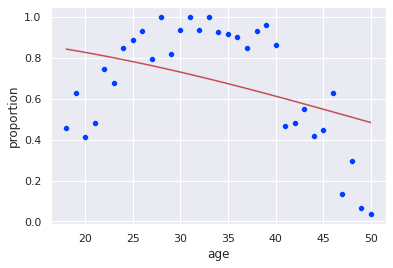

In [24]:
beta0hat = np.mean(results[:,0])
beta1hat = np.mean(results[:,1])
print(beta0hat)
print(beta1hat)
"Having estimated the parameters, let us visualise the actual data compared"
"with the expected values of the probabilites implied by these estimates"
ti = beta0hat + beta1hat*C.age
pi = scipy.stats.norm.cdf(ti)
sns.scatterplot(x=C.age, y=C.proportion)
plt.plot(C.age, pi, color='r')

Clearly the fitted probabilities don't follow the data very well. Originally we modelled the probabilities as p_i = PHI(beta_0 + beta_1*z_i). The linear relationship inside PHI() doesn't allow the probabilities to first increase and then decrease with age, as seen in the data. To fix this we slightly amend the model so that p_i = PHI(beta_0 + beta_1*z_i + beta_2*z_i^2) 

0.7666666666666667


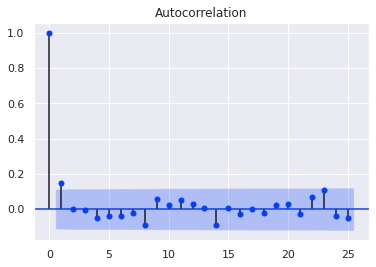

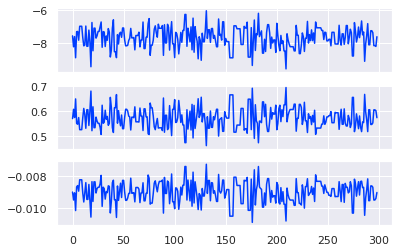

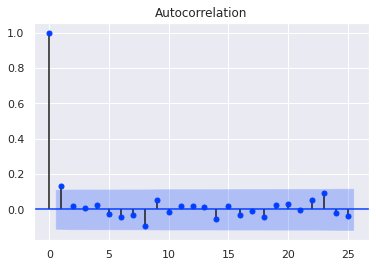

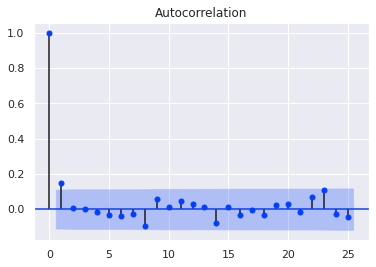

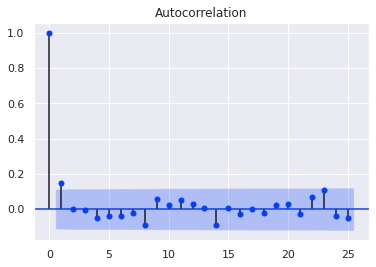

In [26]:
"define new potential energy function (minus log of posterior distribution)"
def U(beta):
  p = scipy.stats.norm.cdf(beta[0] + beta[1]*C.age + beta[2]*C.age**2)
  val = scipy.stats.binom.pmf(C.use, C.total, p)
  lp = -sum(np.log(val)) + beta[0]**2/200 + beta[1]**2/200 + beta[2]**2/200 
  return lp
"find the new gradient"  
def gradU(beta):
  t = beta[0]+beta[1]*C.age+beta[2]*C.age**2
  a = C.use*scipy.stats.norm.pdf(t)/scipy.stats.norm.cdf(t)
  b = (C.use - C.total)*scipy.stats.norm.pdf(t)/(1-scipy.stats.norm.cdf(t))
  grad0 = - sum(a) - sum(b) + beta[0]/100
  grad1 = - sum(a*C.age) - sum(b*C.age) + beta[1]/100
  grad2 = - sum(a*C.age**2) - sum(b*C.age**2) + beta[2]/100
  return np.array([grad0, grad1, grad2])

n=300
epsilons = np.array([0.002, 0.0001, 0.00003])
[results, accrate] = HMC(U, gradU, epsilons, 900, np.array([-7.57, 0.57, -0.009]), n) 
"Tune epsilon and L appropriately to obtain low autocorrelation and acceptance rate close"
"to theoretical optimal value 0.65, Neal (2011)"
print(accrate/n)
from matplotlib import pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=False, sharex=True)
ax1.plot(range(n-1), results[:,0])
ax2.plot(range(n-1), results[:,1])
ax3.plot(range(n-1), results[:,2])
import statsmodels.graphics.tsaplots
statsmodels.graphics.tsaplots.plot_acf(results[:,0])  
statsmodels.graphics.tsaplots.plot_acf(results[:,1])
statsmodels.graphics.tsaplots.plot_acf(results[:,2])    

-7.681417827936008
0.5726496921814233
-0.008995113756356872


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWar

420.55898777820636 180.59775813351865


'The BIC for the second model is much smaller hence confirming it is the more appropriate model for the data'

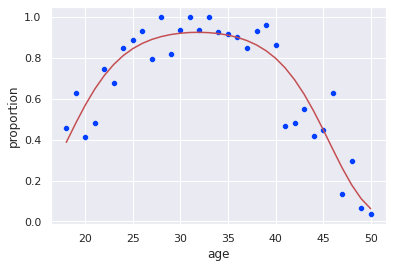

In [27]:
from scipy.optimize import minimize
beta0hat = np.mean(results[:,0])
beta1hat = np.mean(results[:,1])
beta2hat = np.mean(results[:,2])
print(beta0hat)
print(beta1hat)
print(beta2hat)
ti = beta0hat + beta1hat*C.age + beta2hat*C.age**2
pi = scipy.stats.norm.cdf(ti)
sns.scatterplot(x=C.age, y=C.proportion)
plt.plot(C.age, pi, color='r')
"Clearly the fitted probabilities of this updated model are better than previously"
"We also calculate the BIC for each of the two models to confirm what we see in the plots"
"To calculate BIC we first need to find the MLEs for both of the models"
def NLL1(beta):
  p = scipy.stats.norm.cdf(beta[0] + beta[1]*C.age)
  val = scipy.stats.binom.pmf(C.use, C.total, p)
  lp = -sum(np.log(val))
  return lp
x0 = np.array([1.5, -0.03])  
opt1 = scipy.optimize.minimize(NLL1, x0, method='BFGS')

def NLL2(beta):
  p = scipy.stats.norm.cdf(beta[0] + beta[1]*C.age + beta[2]*C.age**2)
  val = scipy.stats.binom.pmf(C.use, C.total, p)
  lp = -sum(np.log(val))
  return lp
x0 = np.array([-7,0.5,-0.01])
opt2 = scipy.optimize.minimize(NLL2, x0, method='BFGS')
BIC1 = 2*opt1.fun + 2*math.log(33)
BIC2 = 2*opt2.fun +3*math.log(33)
print(BIC1, BIC2)
"The BIC for the second model is much smaller hence confirming it is the more appropriate model for the data"

We are interested in finding the age at which the use of contraceptives is maximal. To do this we must maximise PHI(beta_0 + beta_1*z + beta_2*z^2). Since the CDF of the standard normal is strictly increasing this is equivalent to maximising the quadratic function. Differentiating wrt z gives 2*beta_2*z_i + beta_1. Setting to 0 and solving for z gives:

31.83115342908977


'Distribution and vertical lines showing the upper and lower bounds of the 95% credible interval'

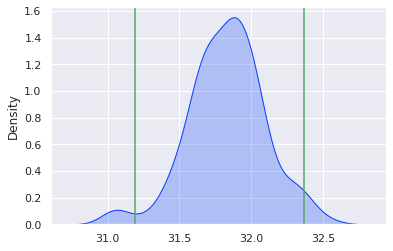

In [32]:
print(-beta1hat/(2*beta2hat))
"we can also find the posterior distribtuion of the age of maximal use using our posterior samples"
ss = -results[:,1]/(2*results[:,2])
sns.kdeplot(ss, fill=True) 
low = np.quantile(ss, 0.025)
upp = np.quantile(ss, 0.975)
plt.axvline(low, color='g')
plt.axvline(upp, color='g')
"Distribution and vertical lines showing the upper and lower bounds of the 95% credible interval"